<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_irrigation_runoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created: October 2024

Purpose: Find the amount of surface runoff from irrigation for each reach monthly. This data came from the Freshwater Trust.

In [2]:
#-------------------------------------------#
#     Import Packages & Connect to Drive    #
#-------------------------------------------#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# --------------- #
#   Load Files    #
# --------------- #

# FWT shapefile of irrigation type based on ML, satellite imagery, & OpenET
irrigation_runoff = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/irrigation_runoff/irrigation_runoff.shp')

# reach delineation
reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final/Reaches_Final.shp')

In [22]:
# ------------------------ #
# Crop FWT data to Reaches
# ------------------------ #

# match CRS between irrigation runoff and reaches
if irrigation_runoff.crs != reaches.crs:
    reaches = reaches.to_crs(irrigation_runoff.crs)

# Combine irrigation runoff with reach information
reach_runoff = gpd.sjoin(irrigation_runoff, reaches[['Reach', 'geometry']], how="inner", predicate="intersects")
reach_runoff = reach_runoff.rename(columns={'Reach': 'reach'})

# Calculate individual Runoff Volume (AF)
reach_runoff['runoff(af)'] = (reach_runoff['flow'] / 12) * reach_runoff['acres']
reach_runoff = reach_runoff.rename(columns={'reach': 'Reach'})
reach_runoff = reach_runoff.drop(columns='geometry')
reach_runoff.to_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_irrigation_runoff.csv', index=False)

In [23]:
# ----------------------------- #
# Calculate Monthly Runoff Volume
# ----------------------------- #

runoff = reach_runoff.groupby(['Reach', 'month'], as_index=False)['runoff(af)'].sum()

# Divide the "annual" runoff by 12 and add to each month within that reach
annual_data = runoff[runoff['month'] == 'annual']
monthly_data = runoff[runoff['month'] != 'annual']

# Update monthly data by adding the distributed annual runoff
for reach in annual_data['Reach'].unique():
    # Get the annual runoff for the reach
    annual_runoff = annual_data.loc[annual_data['Reach'] == reach, 'runoff(af)'].iloc[0]
    monthly_portion = annual_runoff / 12

    # Add the monthly portion to all months within the same reach
    monthly_data.loc[monthly_data['Reach'] == reach, 'runoff(af)'] += monthly_portion
runoff_final = monthly_data

# Save the summarized data to a CSV file
output_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_runoff_final.csv'
runoff_final.to_csv(output_path, index=False)
runoff_final

,Reach,month,runoff(af)
1,Noble Drain,apr,4052.084260
2,Noble Drain,aug,7248.179948
3,Noble Drain,dec,2510.000970
4,Noble Drain,feb,2749.928509
5,Noble Drain,jan,2678.553901
...,...,...,...
86,Solomon Reach,mar,1466.995211
87,Solomon Reach,may,4034.537132
88,Solomon Reach,nov,1361.547437
89,Solomon Reach,oct,1905.912218


<ipython-input-41-ff839ea08cd2>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-41-ff839ea08cd2>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-41-ff839ea08cd2>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-41-ff839ea08cd2>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-41-ff839ea08cd2>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-41-ff839ea08cd2>:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


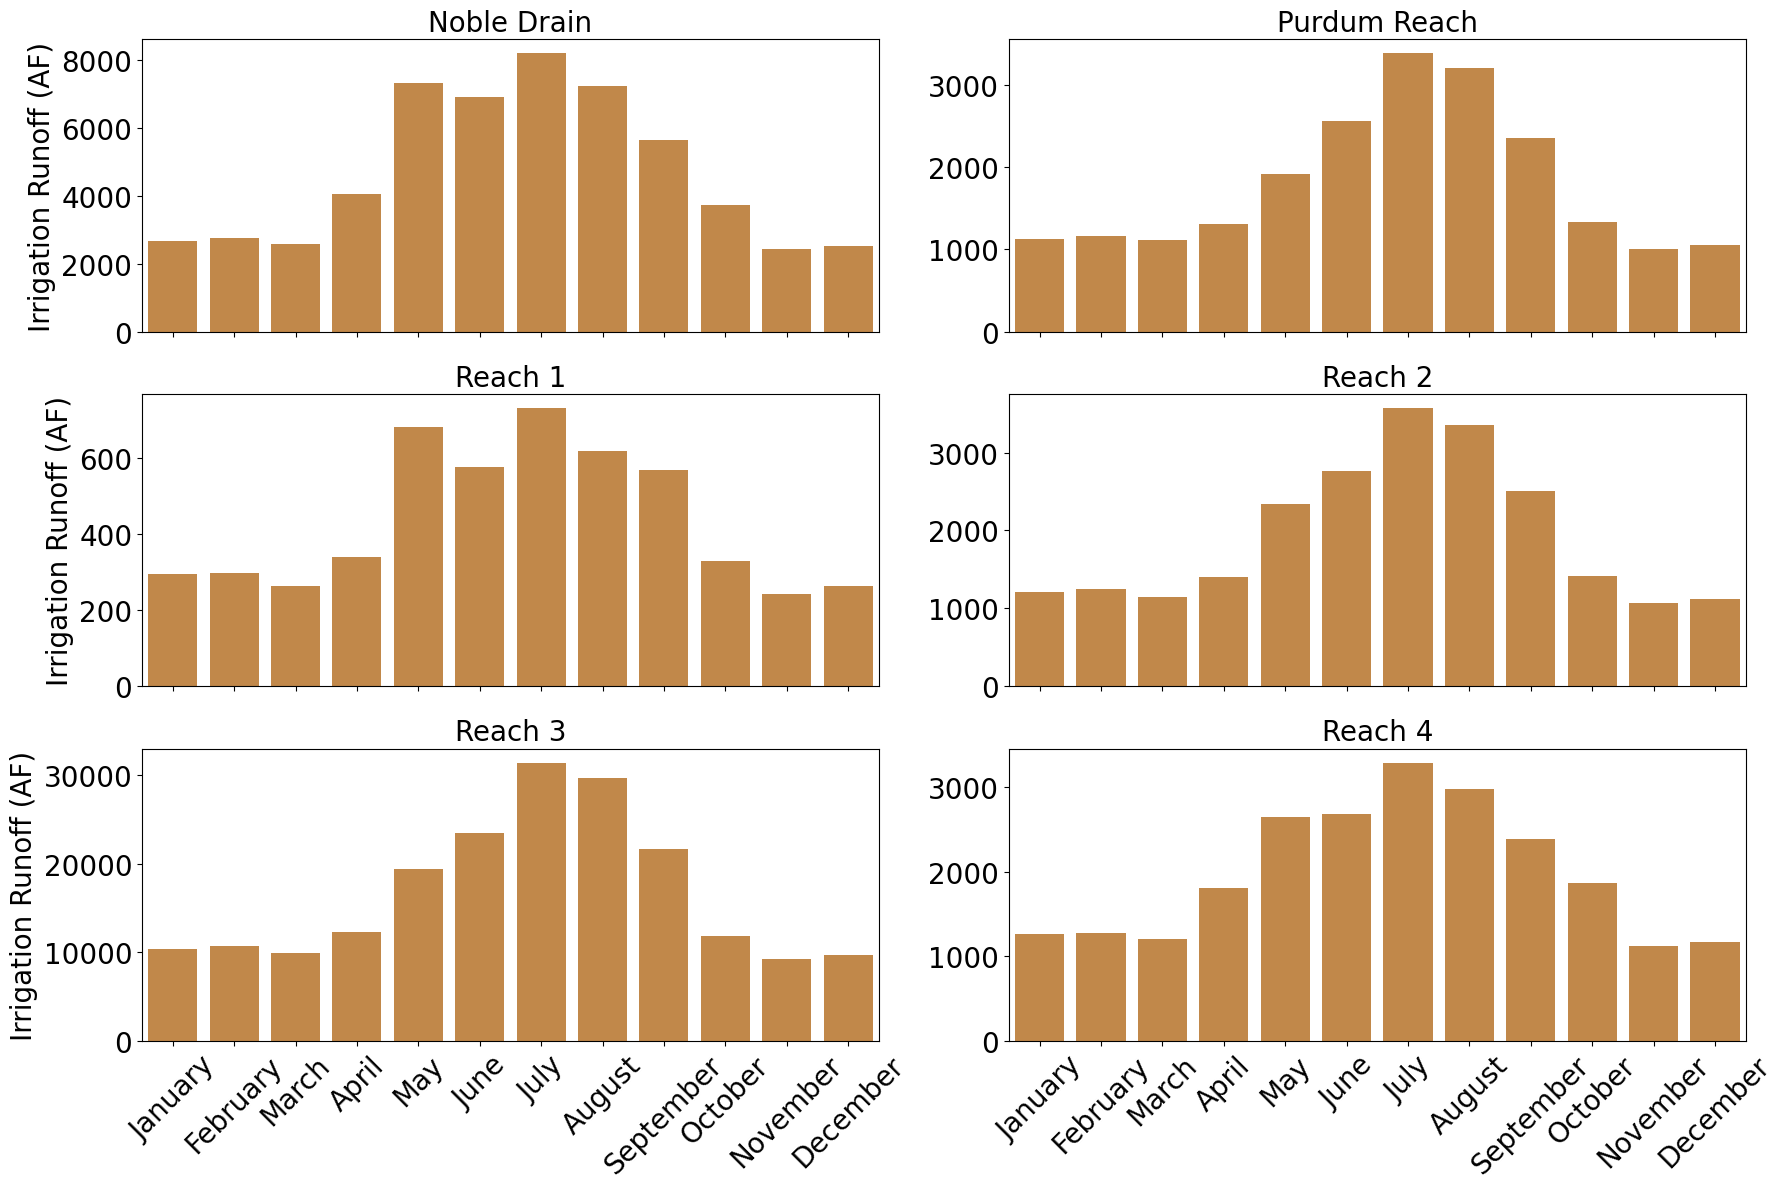

In [41]:
# ------------------------------ #
# Plot of Reach Irrigation Runoff
# ------------------------------ #

data = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_runoff_final.csv')

# Define the order of months with full names
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert abbreviated month names to full names
if data['month'].str.len().max() == 3:  # Likely abbreviated month names
    data['month'] = pd.to_datetime(data['month'], format='%b').dt.strftime('%B')

# Ensure the 'month' column is ordered
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

reaches = data['Reach'].unique()

# Create a 3x2 panel (6 plots)
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

# Iterate over each reach and create a plot
for i, reach in enumerate(reaches):
    if i < len(axes):
        ax = axes[i]
        sns.barplot(
            data=data[data['Reach'] == reach],
            x='month', y='runoff(af)', color='#D58936', ci=None, ax=ax,
            order=month_order  # x-axis is ordered by actual months
        )
        ax.set_title(reach, fontsize=20)

        # Remove x-axis labels except for the bottom panels
        if i < len(axes) - 2:  # Not in the last row
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('', fontsize=14)

        # Remove the major y-axis name (ylabel) except for the leftmost panels
        if i % 2 != 0:  # Not in the left column
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Irrigation Runoff (AF)', fontsize=20)

        # Ensure all plots still have y-tick labels
        ax.tick_params(axis='y', labelsize=20)

        # Customize x-tick labels
        ax.tick_params(axis='x', rotation=45, labelsize=20)

# Remove unused axes
for j in range(len(reaches), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

output_path = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/mason_runoff_panel.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

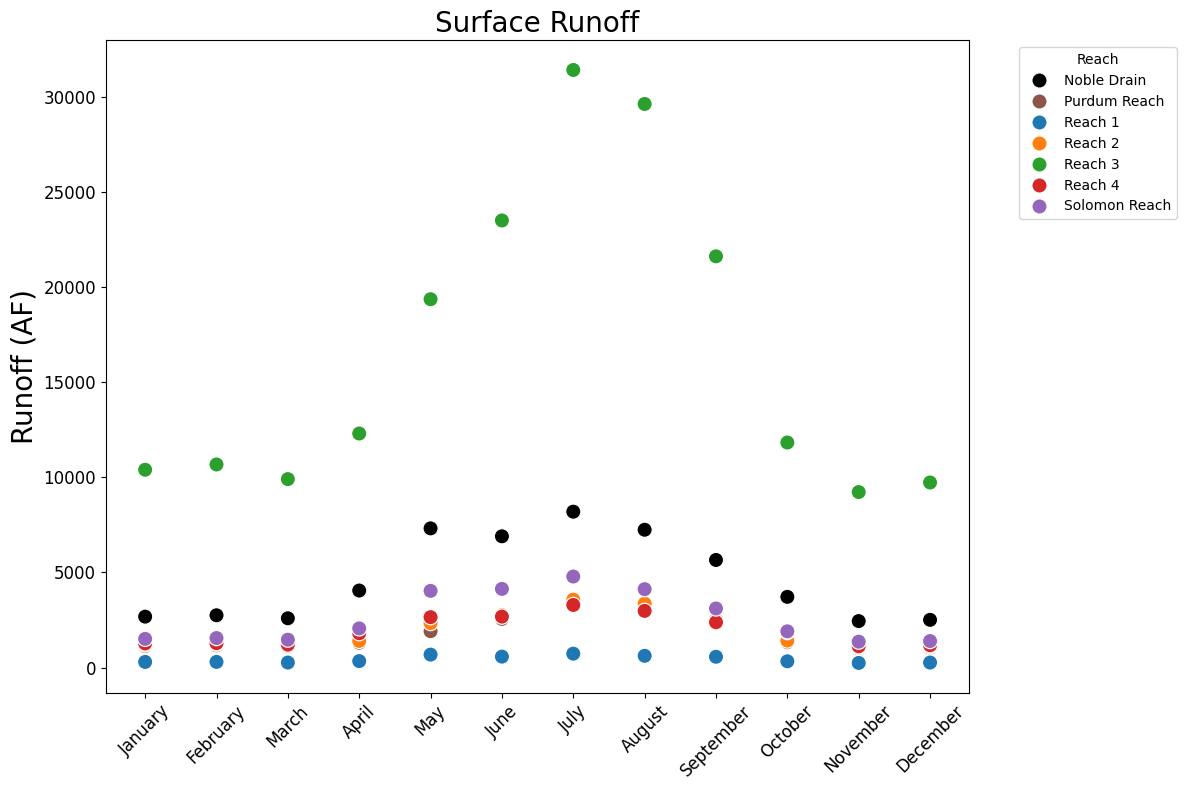

<Figure size 640x480 with 0 Axes>

In [38]:
# ------------ #
# SCATTER PLOT
# ------------ #

data = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_runoff_final.csv')

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert abbreviated month names to full names if necessary
if data['month'].str.len().max() == 3:  # Likely abbreviated month names
    data['month'] = pd.to_datetime(data['month'], format='%b').dt.strftime('%B')

# Set the 'month' column as a categorical type with the specified order
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

# Define colors and markers
reach_colors = {
    'Reach 1': '#1f77b4',  # Blue
    'Reach 2': '#ff7f0e',  # Orange
    'Reach 3': '#2ca02c',  # Green
    'Reach 4': '#d62728',  # Red
    'Solomon Reach': '#9467bd',  # Purple
    'Purdum Reach': '#8c564b',  # Brown
    'Noble Drain': 'black'
}

reach_markers = {
    'Reach 1': 'o',
    'Reach 2': 'o',
    'Reach 3': 'o',
    'Reach 4': 'o',
    'Solomon Reach': 'o',
    'Purdum Reach': 'o',
    'Noble Drain': 'o'
}

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data,
    x='month',
    y='runoff(af)',
    hue='Reach',
    style='Reach',
    palette=reach_colors,
    markers=reach_markers,
    s=120
)

# Customize the plot
plt.title('Surface Runoff', fontsize=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Runoff (AF)', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Move the legend outside of the plot
plt.legend(title='Reach', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Show the plot
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/irrigation_runoff_out/reach_runoff_scatter.png', dpi=300, bbox_inches='tight')
plt.show()